# Captain Agent
By: Linxin Song, Jiale Liu, Jieyu Zhang

In this notebook, we introduce CaptainAgent, an agent enhanced with the capability to call AutoBuild to break down and solve complex tasks. AutoBuild can initiate a nested chat between a group of experts and converse to solve the task. The experts in nested chat can be retrieved from agent library. The agents can be equipped with tools for advanced coding. In addition to agent library, we release a tool library that can assist with advanced tasks.

````{=mdx}
:::info Requirements
Install `pyautogen`:
```bash
pip install pyautogen[autobuild]
```

For more information, please refer to the [installation guide](/docs/installation/).
:::
````

## Setup API endpoint
In order to setup API, you should create a OAI_CONFIG_LIST file. The config list should look like the following:
```python
config_list = [
    {
        'model': 'gpt-4-1106-preview',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2024-02-15-preview',
    },
    {
        'model': 'gpt-3.5-turbo-16k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2024-02-15-preview',
    },
]
```

````{=mdx}
:::tip
Learn more about configuring LLMs for agents [here](/docs/topics/llm_configuration).
:::
````

In [1]:
import autogen

config_file_or_env = "OAI_CONFIG_LIST"
llm_config = {"temperature": 0}
config_list = autogen.config_list_from_json(
    config_file_or_env, filter_dict={"model": ["gpt-4-1106-preview", "gpt-4"]}
)  # You can modify the filter_dict to select the models

## Using CaptainAgent without Retrieval
We begin with demonstrating how to use CaptainAgent without retrieval. In this case, the experts needed for task solving will be identified and generated by LLM, then put into a nested chat to converse.

In [2]:
from autogen.agentchat.contrib.captain_agent import CaptainAgent
from autogen.agentchat.contrib.captain_user_proxy_agent import CaptainUserProxyAgent

general_llm_config = {
    "temperature": 0,
    "config_list": autogen.config_list_from_json("OAI_CONFIG_LIST", filter_dict={"model": ["gpt-4-1106-preview"]}),
}

nested_mode_config = {
    "autobuild_init_config": {
        "config_file_or_env": "OAI_CONFIG_LIST",
        "builder_model": "gpt-4-1106-preview",
        "agent_model": "gpt-4-1106-preview",
    },
    # this is used to configure the autobuild building process
    "autobuild_build_config": {
        "default_llm_config": {"temperature": 1, "top_p": 0.95, "max_tokens": 1500, "seed": 52},
        # this is used to configure the user proxy within nested chat
        "code_execution_config": {"timeout": 300, "work_dir": "groupchat", "last_n_messages": 1},
        "coding": True,
    },
    "group_chat_config": {"max_round": 15},
    "group_chat_llm_config": general_llm_config.copy(),
}

## build agents
captain_agent = CaptainAgent(name="captain_agent", llm_config=general_llm_config, nested_mode="autobuild")
captain_user_proxy = CaptainUserProxyAgent(
    name="captain_user_proxy",
    nested_mode_config=nested_mode_config,
    code_execution_config={"use_docker": False},  # you can modify the setting
    agent_config_save_path=None,  # If you'd like to save the created agents in nested chat for further use, specify the path here
)

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
result = captain_user_proxy.initiate_chat(
    captain_agent,
    message="Let's play game of 24. Given 4 numbers, you need to use +, -, *, / to get 24. The numbers are 2, 2, 7, 12.",
)

captain_user_proxy (to captain_agent):

Let's play game of 24. Given 4 numbers, you need to use +, -, *, / to get 24. The numbers are 2, 2, 7, 12.

--------------------------------------------------------------------------------
captain_agent (to captain_user_proxy):

***** Suggested tool call (call_q92sgqSsB1RmJl36z77J6fhs): seek_experts_help *****
Arguments: 
{
  "group_name": "Game of 24 Solvers",
  "building_task": "- Mathematician: An expert in mathematical problem-solving, particularly skilled in operations like addition, subtraction, multiplication, and division. This expert should be able to think creatively to find ways to combine four numbers to reach a target sum.\n- Puzzle Solver: An individual with experience in solving numerical puzzles and games, who can approach the problem from a different angle and suggest alternative solutions.\n- Checker: A role dedicated to verifying the correctness of the proposed solutions. This expert should have a strong attention to detail and

## Building Agents from library & Retrieve tools from tool library
One significant feature of CaptainAgent is that the experts and tools can be retrieved from a dedicated library.

`captainagent_expert_library.json` contains examples of experts. You can customize your own expert library following the same json format.

We provide a list of tools in `autogen/agentchat/contrib/captainagent/tools` directory, it is categorized into three types: data analysis, information_retrieval, math.

### Using Agent Library Only
Below is an example that retrieves experts from library and build nested chat accordingly.


In [4]:
from autogen.agentchat.contrib.captain_agent import CaptainAgent
from autogen.agentchat.contrib.captain_user_proxy_agent import CaptainUserProxyAgent

general_llm_config = {
    "temperature": 0,
    "config_list": autogen.config_list_from_json("OAI_CONFIG_LIST", filter_dict={"model": ["gpt-4-1106-preview"]}),
}

nested_mode_config = {
    "autobuild_init_config": {
        "config_file_or_env": "OAI_CONFIG_LIST",
        "builder_model": "gpt-4-1106-preview",
        "agent_model": "gpt-4-1106-preview",
    },
    # this is used to configure the autobuild building process
    "autobuild_build_config": {
        "default_llm_config": {"temperature": 1, "top_p": 0.95, "max_tokens": 1500, "seed": 52},
        # this is used to configure the user proxy within nested chat
        "code_execution_config": {"timeout": 300, "work_dir": "groupchat", "last_n_messages": 1},
        "coding": True,
        "library_path_or_json": "captainagent_expert_library.json",
    },
    "group_chat_config": {"max_round": 15},
    "group_chat_llm_config": general_llm_config.copy(),
}

Now let's instantiate the agents and ask it to solve a problem.

In [6]:
## build agents
captain_agent = CaptainAgent(name="captain_agent", llm_config=general_llm_config, nested_mode="autobuild")
captain_user_proxy = CaptainUserProxyAgent(
    name="captain_user_proxy",
    nested_mode_config=nested_mode_config,
    code_execution_config={"use_docker": False},
    agent_config_save_path=None,  # If you'd like to save the created agents in nested chat for further use, specify the path here
)

query = 'Find the stock price of Microsoft in the past 1 year and plot a line chart to show the trend. Save the line chart as "microsoft_stock_price.png".'

result = captain_user_proxy.initiate_chat(captain_agent, message=query, max_turns=3)

captain_user_proxy (to captain_agent):

Find the stock price of Microsoft in the past 1 year and plot a line chart to show the trend. Save the line chart as "microsoft_stock_price.png".

--------------------------------------------------------------------------------


captain_agent (to captain_user_proxy):

***** Suggested tool call (call_jA3q8bUfy1UCOt2MKY7SWHiY): seek_experts_help *****
Arguments: 
{
  "group_name": "Stock Analysis Team",
  "building_task": "- Data Analyst: An expert who can gather historical stock price data for Microsoft over the past year. This person should be familiar with financial databases, APIs, or web scraping techniques to extract the required data.\n- Data Visualization Specialist: An individual skilled in data visualization who can plot the gathered stock price data into a clear and informative line chart. They should be proficient in using data visualization libraries such as Matplotlib or Seaborn in Python.\n- Quality Assurance Analyst: A professional who can verify the accuracy of the data collected and the correctness of the visualization. They should ensure that the line chart accurately represents the stock price trend and that the file is saved correctly as 'microsoft_stock_price.png'.",
  "execution_task": "##

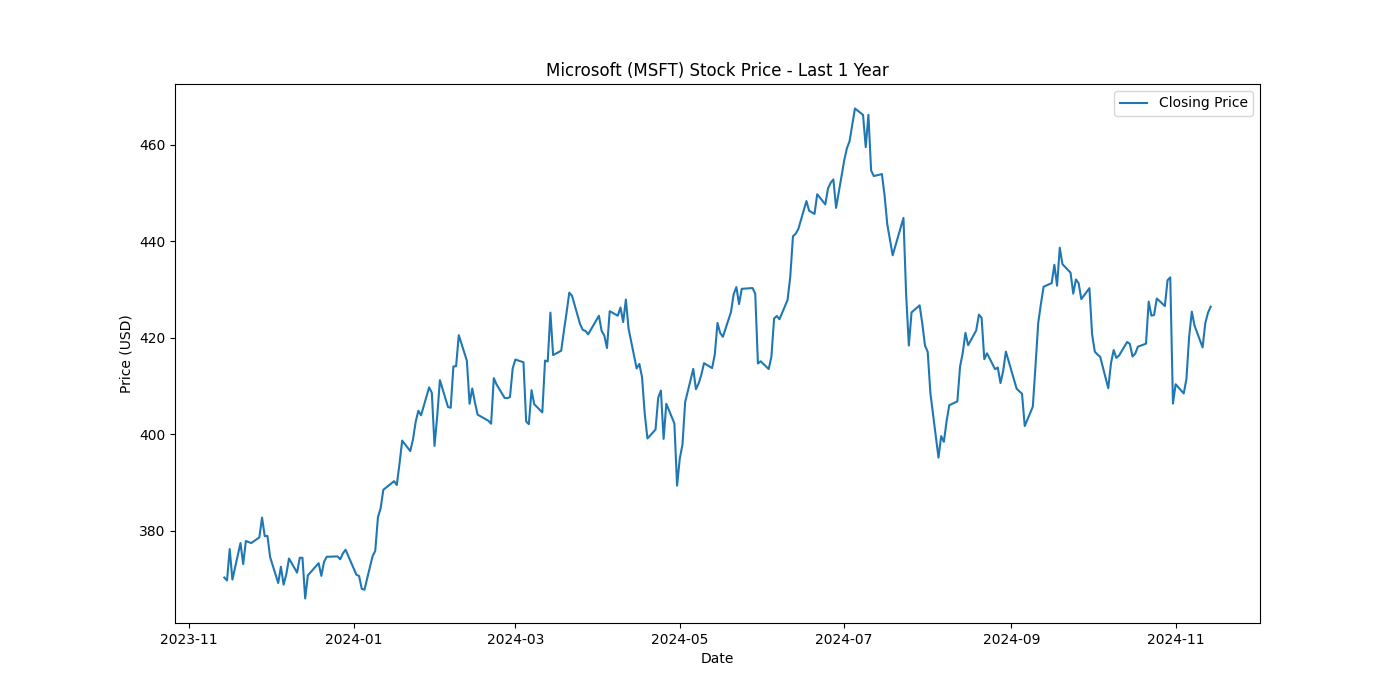

In [7]:
from IPython.display import Image

Image("groupchat/microsoft_stock_price.png")

## Using Both Agent Library and Tool Library
Now let's retrieve from both agent library and tool library while building experts for nested chat.

To run the following demo, it is required to install the dependencies and obtain BING search api and Rapid API key for tools in library to fully function. Refer to instructions [here](/docs/topics/captainagent/tool).

In [ ]:
from autogen.agentchat.contrib.captain_agent import CaptainAgent
from autogen.agentchat.contrib.captain_user_proxy_agent import CaptainUserProxyAgent

nested_mode_config = {
    "autobuild_init_config": {
        "config_file_or_env": "OAI_CONFIG_LIST",
        "builder_model": "gpt-4-1106-preview",
        "agent_model": "gpt-4-1106-preview",
    },
    # this is used to configure the autobuild building process
    "autobuild_build_config": {
        "default_llm_config": {"temperature": 1, "top_p": 0.95, "max_tokens": 1500, "seed": 52},
        # this is used to configure the user proxy within nested chat
        "code_execution_config": {"timeout": 300, "work_dir": "groupchat", "last_n_messages": 1},
        "coding": True,
        "library_path_or_json": "captainagent_expert_library.json",
    },
    # this is used to configure the tool library
    "autobuild_tool_config": {
        "tool_root": "default",  # this will use the tool library we provide
        "retriever": "all-mpnet-base-v2",
    },
    # this is used to configure the group chat
    "group_chat_config": {"max_round": 15},
    "group_chat_llm_config": general_llm_config.copy(),
}

In [ ]:
# The function requires BING api key and Rapid API key to work. You can follow the instructions from docs to get one.
import os

os.environ["BING_API_key"] = ""  # set your bing api key here, if you donot need search engine, you can skip this step
os.environ["RAPID_API_KEY"] = (
    ""  # set your rapid api key here, in order for this example to work, you need to subscribe to the youtube transcription api(https://rapidapi.com/solid-api-solid-api-default/api/youtube-transcript3)
)

## build agents
captain_agent = CaptainAgent(name="captain_agent", llm_config=general_llm_config, nested_mode="autobuild")
captain_user_proxy = CaptainUserProxyAgent(
    name="captain_user_proxy",
    nested_mode_config=nested_mode_config,
    code_execution_config={"use_docker": False},
    agent_config_save_path=None,  # If you'd like to save the created agents in nested chat for further use, specify the path here
)

query = """# Task
Your task is to solve a question given by a user.

# Question
Examine the video at https://www.youtube.com/watch?v=1htKBjuUWec.

What does Teal'c say in response to the question "Isn't that hot?"
""".strip()
result = captain_user_proxy.initiate_chat(captain_agent, message=query)

captain_user_proxy (to captain_agent):

# Task
Your task is to solve a question given by a user.

# Question
Examine the video at https://www.youtube.com/watch?v=1htKBjuUWec.

What does Teal'c say in response to the question "Isn't that hot?"

--------------------------------------------------------------------------------
captain_agent (to captain_user_proxy):

***** Suggested tool call (call_IDSuIZP7uONGc5RjQ6UcqLLN): seek_experts_help *****
Arguments: 
{
  "group_name": "Video Analysis Experts",
  "building_task": "- Video Content Analyst: An expert who specializes in watching and analyzing video content to extract specific information, such as dialogues, scenes, or actions.\n- Linguistic Analyst: An expert in understanding and interpreting spoken language in various accents and dialects, capable of accurately transcribing spoken words from videos.\n- Verification Specialist: A checker who verifies the accuracy of the information provided by the other experts, ensuring that the tran

The ground truth answer to the question is 'Extremely', which the CaptainAgent answers correctly. Notably, with the assistance of tools, the agent can answer video-related questions. This shows the huge potential of what user customized tools can bring.